In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
import joblib

In [8]:
# Load with semicolon as separator
df = pd.read_csv("air-quality-in-nairobi.csv", sep=";")
df.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,128,SDS011,68,-1.376,36.929,2019-09-01T00:00:02.236776+00:00,P2,7.20
1,128,SDS011,68,-1.376,36.929,2019-09-01T00:00:02.236776+00:00,P1,10.03
2,127,DHT22,68,-1.376,36.929,2019-09-01T00:00:05.613250+00:00,humidity,99.90
3,127,DHT22,68,-1.376,36.929,2019-09-01T00:00:05.613250+00:00,temperature,16.10
4,79,SDS011,30,-1.290,36.777,2019-09-01T00:00:06.128592+00:00,P2,6.93


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719404 entries, 0 to 719403
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    719404 non-null  int64  
 1   sensor_type  719404 non-null  object 
 2   location     719404 non-null  int64  
 3   lat          719404 non-null  float64
 4   lon          719404 non-null  float64
 5   timestamp    719404 non-null  object 
 6   value_type   719404 non-null  object 
 7   value        719404 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 43.9+ MB


In [10]:
# pivot so each value_type becomes its own column; group by timestamp & location
df_wide = df.pivot_table(
    index=['timestamp','location'],
    columns='value_type',
    values='value',
    aggfunc='mean'
).reset_index()

# Flatten columns
df_wide.columns.name = None
df_wide = df_wide.rename_axis(None, axis=1)
df_wide.head()

,timestamp,location,P1,P2,humidity,temperature
0,2019-09-01T00:00:02.236776+00:00,68,10.03,7.20,NaN,NaN
1,2019-09-01T00:00:05.613250+00:00,68,NaN,NaN,99.9,16.1
2,2019-09-01T00:00:06.128592+00:00,30,10.40,6.93,NaN,NaN
3,2019-09-01T00:00:08.844578+00:00,30,NaN,NaN,99.9,17.3
4,2019-09-01T00:00:09.836965+00:00,59,0.10,0.10,NaN,NaN


In [11]:
# Create AQI labels from PM2.5 values
def pm25_to_aqi(pm):
    if pd.isna(pm):
        return None
    pm = float(pm)
    if pm <= 12.0:
        return "Good"
    elif pm <= 35.4:
        return "Moderate"
    elif pm <= 55.4:
        return "Unhealthy-Sensitive"
    elif pm <= 150.4:
        return "Unhealthy"
    elif pm <= 250.4:
        return "Very Unhealthy"
    else:
        return "Hazardous"

df_wide['AQI_Category'] = df_wide['P2'].apply(pm25_to_aqi)

# Simplify into binary category
def simplify_category(cat):
    if cat in ["Good", "Moderate"]:
        return "Healthy"
    else:
        return "Unhealthy"

df_wide['Air_Quality'] = df_wide['AQI_Category'].apply(simplify_category)

# Show results

print("Class counts:\n", df_wide['Air_Quality'].value_counts())


Class counts:
 Air_Quality
Healthy      181366
Unhealthy    178320
Name: count, dtype: int64


In [12]:
df_wide.shape

(359686, 8)

In [13]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359686 entries, 0 to 359685
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   timestamp     359686 non-null  object 
 1   location      359686 non-null  int64  
 2   P1            186444 non-null  float64
 3   P2            186444 non-null  float64
 4   humidity      173257 non-null  float64
 5   temperature   173257 non-null  float64
 6   AQI_Category  186444 non-null  object 
 7   Air_Quality   359686 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 22.0+ MB


In [14]:
# Numerical columns
num_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical Columns:", num_cols)

# Categorical columns
cat_cols = df_wide.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", cat_cols)


Numerical Columns: ['location', 'P1', 'P2', 'humidity', 'temperature']
Categorical Columns: ['timestamp', 'AQI_Category', 'Air_Quality']


In [78]:
df_wide.isnull().sum()

timestamp            0
location             0
P1              173242
P2              173242
humidity        186429
temperature     186429
AQI_Category    173242
Air_Quality          0
dtype: int64

In [15]:
df_wide.describe()

,location,P1,P2,humidity,temperature
count,359686.000000,186444.000000,186444.000000,173257.000000,173257.000000
mean,50.218883,21.653899,11.245230,68.480078,22.996220
std,18.575967,34.982505,14.313417,21.373744,9.949977
min,7.000000,0.000000,0.000000,22.700000,11.800000
25%,29.000000,9.020000,4.870000,51.699829,18.800000
50%,61.000000,14.850000,7.700000,65.900000,21.700000
75%,68.000000,24.370000,12.930000,89.100000,24.800000
max,70.000000,1999.900000,999.900000,99.998474,99.998474


### EDA

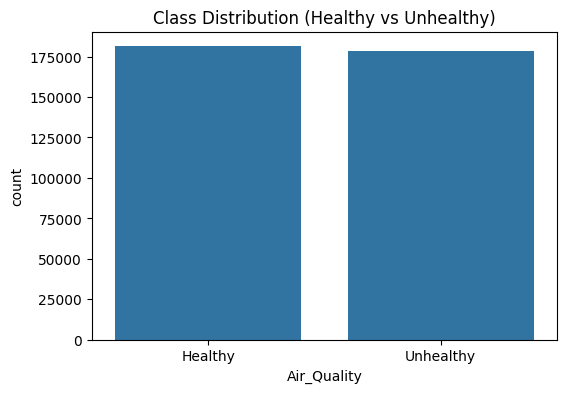

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_wide, x='Air_Quality')
plt.title("Class Distribution (Healthy vs Unhealthy)")
plt.show()

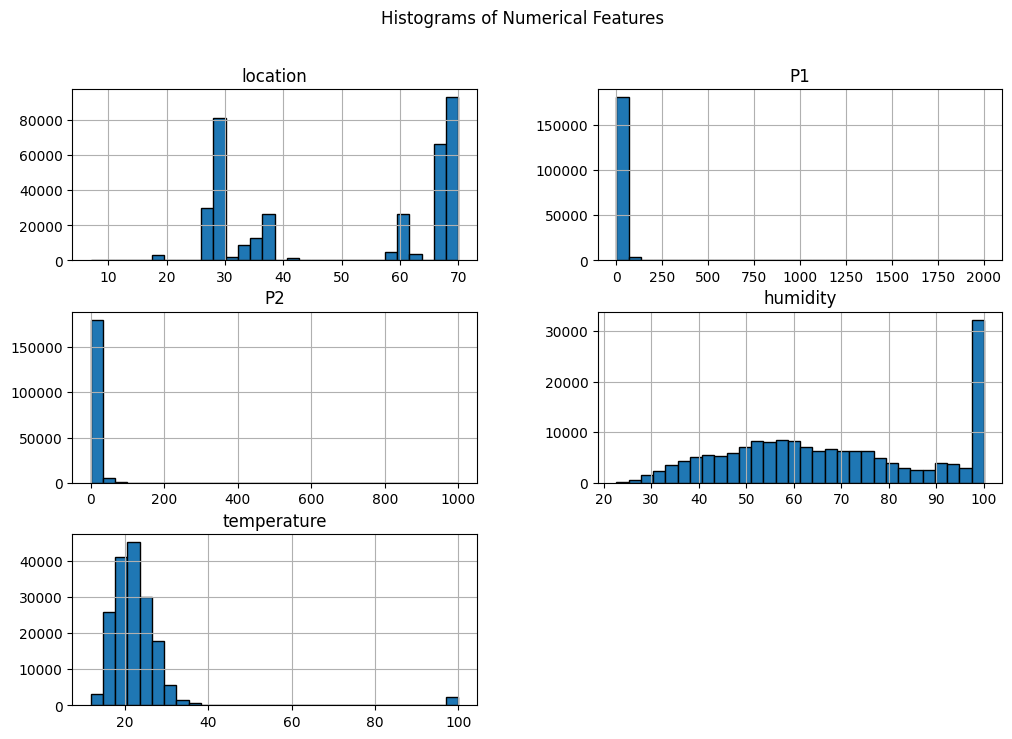

In [12]:
# Numerical columns (excluding timestamp, location, and categorical)
num_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()

# Histograms
df_wide[num_cols].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()

<Figure size 1200x600 with 0 Axes>

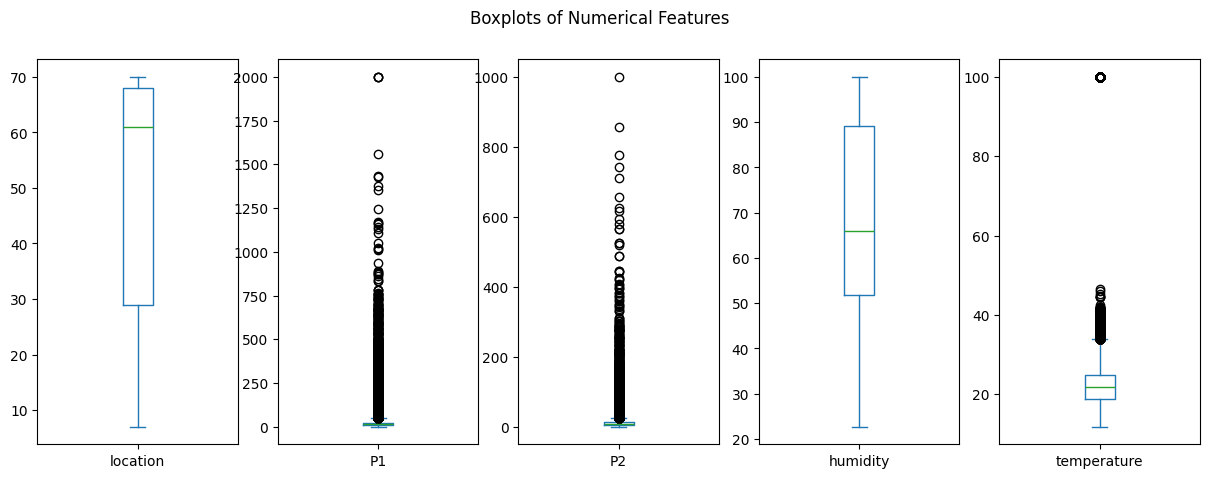

In [13]:
# Boxplots
plt.figure(figsize=(12, 6))
df_wide[num_cols].plot(kind='box', subplots=True, layout=(1, len(num_cols)), figsize=(15, 5), sharey=False)
plt.suptitle("Boxplots of Numerical Features")
plt.show()

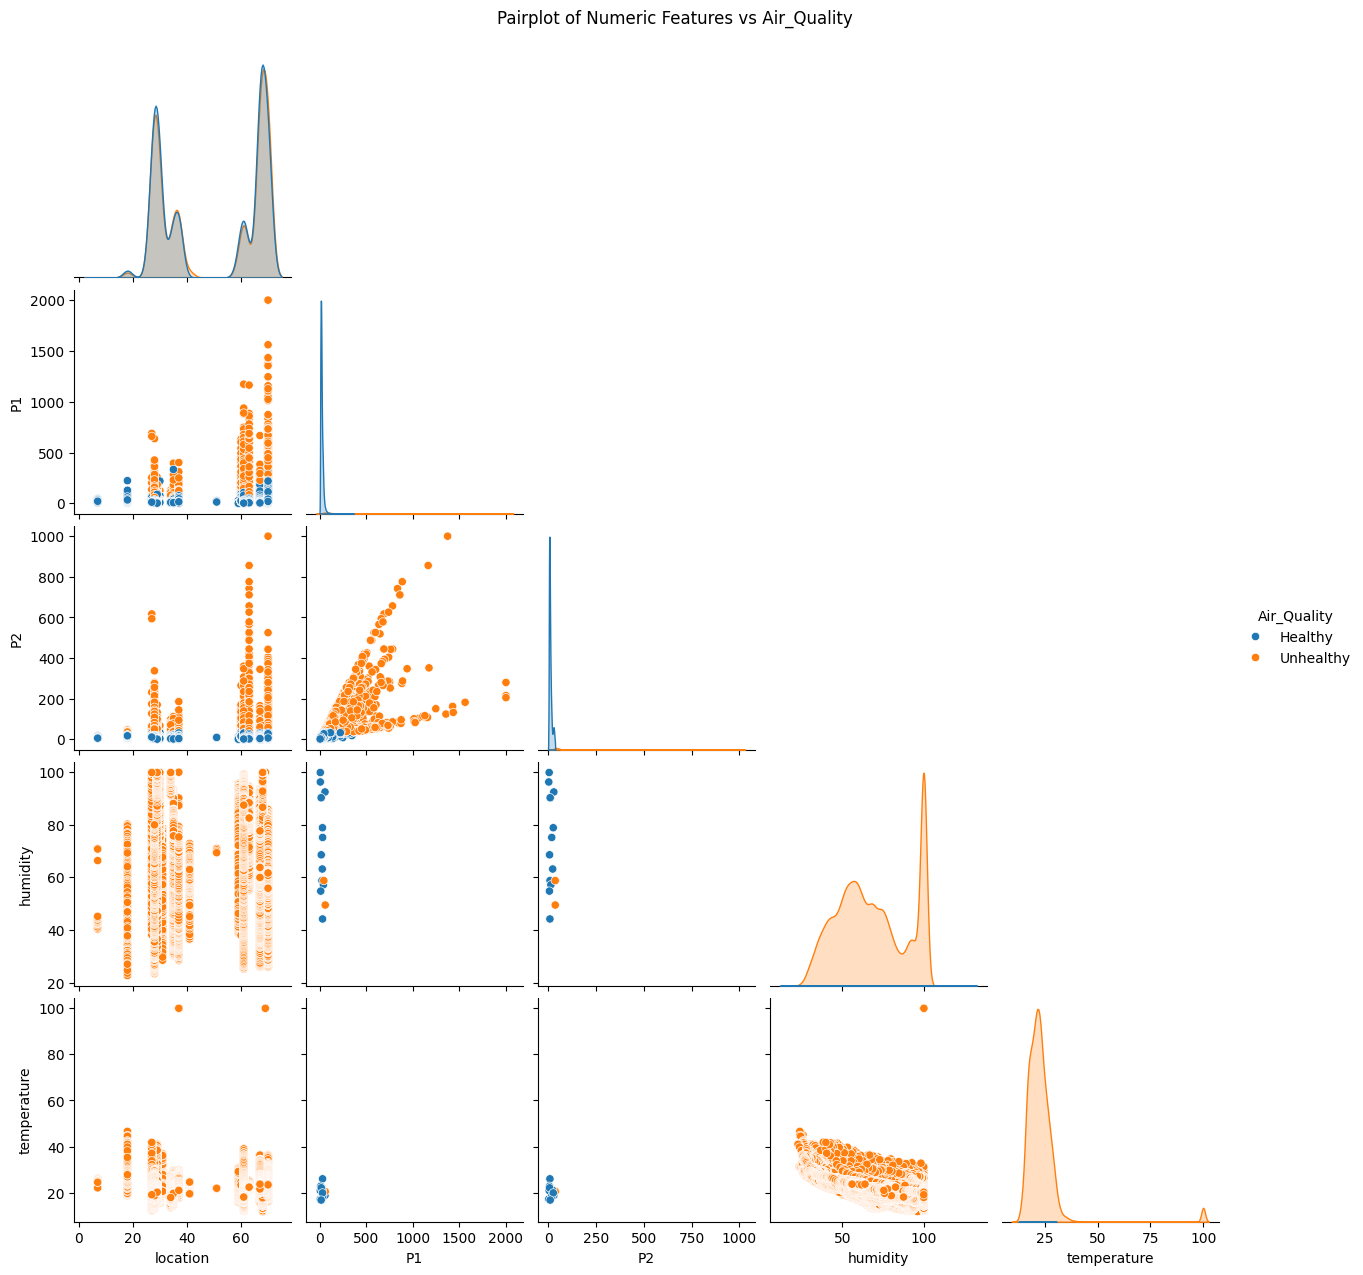

In [14]:
sns.pairplot(df_wide[num_cols + ['Air_Quality']], hue="Air_Quality", diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Numeric Features vs Air_Quality", y=1.02)
plt.show()


In [ ]:
# Plot distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot((len(cat_cols) // 3) + 1, 3, i)  # dynamic rows
    sns.countplot(x=col, data=df_wide, palette="Set2")
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Preprocessing

In [16]:
df_wide.columns

Index(['timestamp', 'location', 'P1', 'P2', 'humidity', 'temperature',
       'AQI_Category', 'Air_Quality'],
      dtype='object')

In [17]:
# Drop columns not useful for prediction
df_wide.drop([ "P1", "P2", "AQI_Category"], axis=1, inplace=True)

# Check remaining columns
print("Remaining columns:", df_wide.columns.tolist())



Remaining columns: ['timestamp', 'location', 'humidity', 'temperature', 'Air_Quality']


In [18]:
# Check number of duplicates before removal
print("Duplicate rows in original dataset:", df_wide.duplicated().sum())

# Remove duplicate rows
df_wide = df_wide.drop_duplicates()

# Check number of duplicates after removal
print("Duplicate rows after removal:", df_wide.duplicated().sum())

#  reset the index after dropping
df_wide.reset_index(drop=True, inplace=True)


Duplicate rows in original dataset: 0
Duplicate rows after removal: 0


In [19]:
print(df_wide.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359686 entries, 0 to 359685
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   timestamp    359686 non-null  object 
 1   location     359686 non-null  int64  
 2   humidity     173257 non-null  float64
 3   temperature  173257 non-null  float64
 4   Air_Quality  359686 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 13.7+ MB
None


In [20]:
df_wide.isnull().sum()

timestamp           0
location            0
humidity       186429
temperature    186429
Air_Quality         0
dtype: int64

In [21]:
# Impute missing humidity and temperature with their median
for col in ['humidity', 'temperature']:
    if df_wide[col].isnull().any():
        median_val = df_wide[col].median()
        df_wide[col] = df_wide[col].fillna(median_val)

print(df_wide[['humidity','temperature']].isnull().sum())


humidity       0
temperature    0
dtype: int64


In [22]:

df_wide['timestamp'] = pd.to_datetime(df_wide['timestamp'], errors='coerce', utc=True)

# Extract hour
df_wide['hour'] = df_wide['timestamp'].dt.hour

# Drop raw timestamp (not useful for ML)
df_wide = df_wide.drop(columns=['timestamp'])

print(df_wide[['hour', 'Air_Quality']].head())



   hour Air_Quality
0     0     Healthy
1     0   Unhealthy
2     0     Healthy
3     0   Unhealthy
4     0     Healthy


In [23]:


# Function to cap outliers using IQR
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Replace values outside bounds with the bounds
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))
    return df

# Apply capping to humidity and temperature
df_capped = df_wide.copy()
for col in ['humidity', 'temperature']:
    df_capped = cap_outliers_iqr(df_capped, col)

print("Outliers capped for humidity and temperature.")
print(df_capped[['humidity','temperature']].describe())


Outliers capped for humidity and temperature.
           humidity   temperature
count  3.596860e+05  3.596860e+05
mean   6.590000e+01  2.170000e+01
std    2.842175e-14  3.552719e-15
min    6.590000e+01  2.170000e+01
25%    6.590000e+01  2.170000e+01
50%    6.590000e+01  2.170000e+01
75%    6.590000e+01  2.170000e+01
max    6.590000e+01  2.170000e+01


In [24]:
df_wide.isnull().sum()

location       0
humidity       0
temperature    0
Air_Quality    0
hour           0
dtype: int64

In [25]:
# Encode Air_Quality: Healthy = 0, Unhealthy = 1
df_wide['Air_Quality'] = df_wide['Air_Quality'].map({
    'Healthy': 1,
    'Unhealthy': 0
})


In [26]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Use sparse_output=False for newer sklearn
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit + transform
loc_encoded = encoder.fit_transform(df_wide[['location']])

# Get new column names
loc_cols = encoder.get_feature_names_out(['location'])

# Build encoded DataFrame
loc_df = pd.DataFrame(loc_encoded, columns=loc_cols, index=df_wide.index)

# Drop old location and join encoded
df_encoded = pd.concat([df_wide.drop(columns=['location']), loc_df], axis=1)

print("Final columns after encoding:")
print(df_encoded.columns.tolist())


Final columns after encoding:
['humidity', 'temperature', 'Air_Quality', 'hour', 'location_7', 'location_18', 'location_27', 'location_28', 'location_29', 'location_30', 'location_31', 'location_34', 'location_35', 'location_37', 'location_41', 'location_51', 'location_59', 'location_60', 'location_61', 'location_63', 'location_67', 'location_68', 'location_69', 'location_70']


In [27]:
df_wide.describe()

,location,humidity,temperature,Air_Quality,hour
count,359686.000000,359686.000000,359686.000000,359686.000000,359686.000000
mean,50.218883,67.142797,22.324376,0.504234,11.532017
std,18.575967,14.890094,6.935964,0.499983,6.931328
min,7.000000,22.700000,11.800000,0.000000,0.000000
25%,29.000000,65.900000,21.700000,0.000000,5.000000
50%,61.000000,65.900000,21.700000,1.000000,12.000000
75%,68.000000,65.900000,21.700000,1.000000,18.000000
max,70.000000,99.998474,99.998474,1.000000,23.000000


### Define features & target

In [28]:
 # Define features (X) and target (y)
X = df_encoded.drop(columns=['Air_Quality'])
y = df_encoded['Air_Quality']

### Split the data

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [30]:
# Sizes of train and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)
print("\n")

X_train shape: (287748, 23)
y_train shape: (287748,)
X_test shape : (71938, 23)
y_test shape : (71938,)




### Scaling

In [31]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# Identify numeric and one-hot columns
num_standard = ['humidity']          # StandardScaler
num_robust = ['temperature']         # RobustScaler
onehot_cols = [c for c in X_train.columns if c.startswith('location_')]

# Column transformer
preprocessor = ColumnTransformer([
    ('std', StandardScaler(), num_standard),
    ('rob', RobustScaler(), num_robust),
    ('pass', 'passthrough', onehot_cols)
])

# Scale training and test sets
X_train_scaled = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    preprocessor.transform(X_test),
    index=X_test.index
)


In [32]:
# Class distribution
print("Training set class distribution:")
print(y_train.value_counts())
print("\nTest set class distribution:")
print(y_test.value_counts())


Training set class distribution:
Air_Quality
1    145092
0    142656
Name: count, dtype: int64

Test set class distribution:
Air_Quality
1    36274
0    35664
Name: count, dtype: int64


### Training and Evaluation

Model: LogisticRegression
Train Accuracy: 0.5802
Test Accuracy : 0.5817

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.58      0.56      0.57    142656
           1       0.58      0.60      0.59    145092

    accuracy                           0.58    287748
   macro avg       0.58      0.58      0.58    287748
weighted avg       0.58      0.58      0.58    287748

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.58      0.56      0.57     35664
           1       0.58      0.60      0.59     36274

    accuracy                           0.58     71938
   macro avg       0.58      0.58      0.58     71938
weighted avg       0.58      0.58      0.58     71938



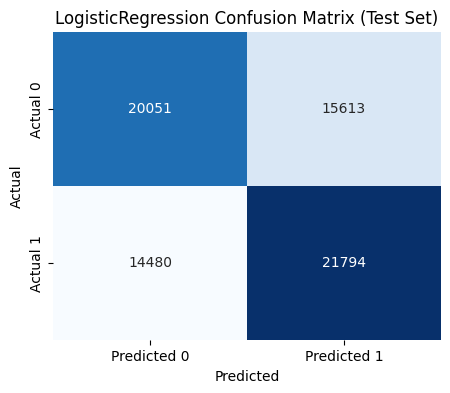


Model: DecisionTree
Train Accuracy: 0.9859
Test Accuracy : 0.9859

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    142656
           1       0.97      1.00      0.99    145092

    accuracy                           0.99    287748
   macro avg       0.99      0.99      0.99    287748
weighted avg       0.99      0.99      0.99    287748

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938



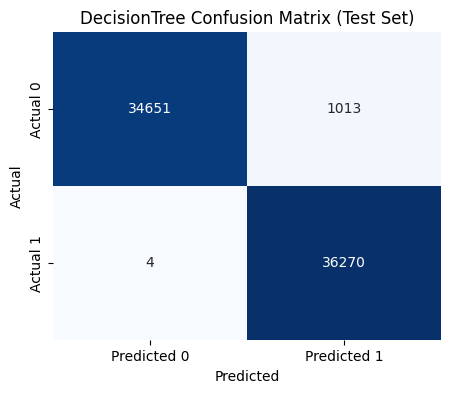


Model: RandomForest
Train Accuracy: 0.9859
Test Accuracy : 0.9859

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    142656
           1       0.97      1.00      0.99    145092

    accuracy                           0.99    287748
   macro avg       0.99      0.99      0.99    287748
weighted avg       0.99      0.99      0.99    287748

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938



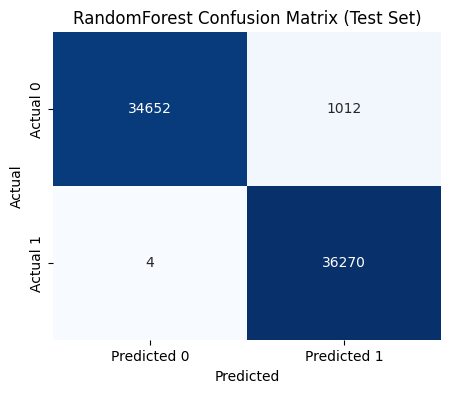


Model: GradientBoosting
Train Accuracy: 0.9858
Test Accuracy : 0.9859

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    142656
           1       0.97      1.00      0.99    145092

    accuracy                           0.99    287748
   macro avg       0.99      0.99      0.99    287748
weighted avg       0.99      0.99      0.99    287748

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938



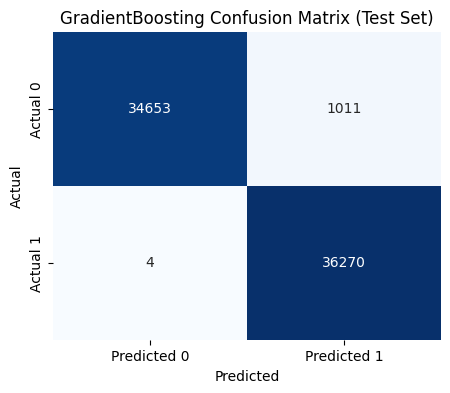


Model: LinearSVM
Train Accuracy: 0.5792
Test Accuracy : 0.5805

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.58      0.56      0.57    142656
           1       0.58      0.60      0.59    145092

    accuracy                           0.58    287748
   macro avg       0.58      0.58      0.58    287748
weighted avg       0.58      0.58      0.58    287748

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.58      0.56      0.57     35664
           1       0.58      0.60      0.59     36274

    accuracy                           0.58     71938
   macro avg       0.58      0.58      0.58     71938
weighted avg       0.58      0.58      0.58     71938



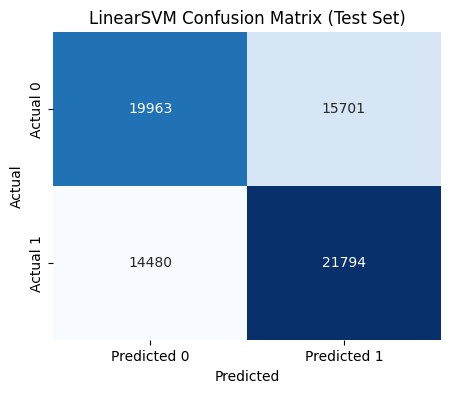

In [33]:
# 3. Train and Evaluate Multiple Models

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LinearSVM': LinearSVC(max_iter=5000, random_state=42)
}

# Iterate over models
for name, model in models.items():
    # Pipeline: preprocessing + model
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train on training data
    pipe.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"Model: {name}")
    print("="*60)
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy : {test_acc:.4f}\n")
    
    # Classification Reports
    print("Classification Report (Training Set):")
    print(classification_report(y_train, y_train_pred))
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0','Predicted 1'],
                yticklabels=['Actual 0','Actual 1'])
    plt.title(f"{name} Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("="*60, "\n")

Model: LogisticRegression
Train Accuracy: 0.5802
Test Accuracy : 0.5817

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.58      0.56      0.57    142656
           1       0.58      0.60      0.59    145092

    accuracy                           0.58    287748
   macro avg       0.58      0.58      0.58    287748
weighted avg       0.58      0.58      0.58    287748

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.58      0.56      0.57     35664
           1       0.58      0.60      0.59     36274

    accuracy                           0.58     71938
   macro avg       0.58      0.58      0.58     71938
weighted avg       0.58      0.58      0.58     71938



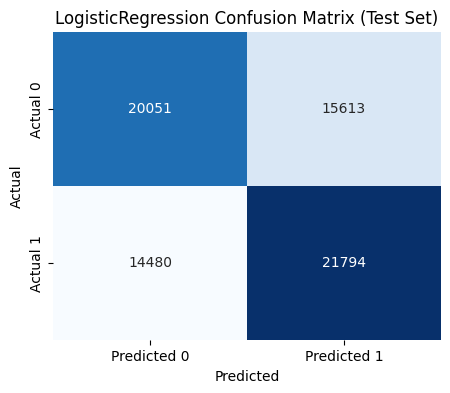


Model: DecisionTree
Train Accuracy: 0.9859
Test Accuracy : 0.9859

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    142656
           1       0.97      1.00      0.99    145092

    accuracy                           0.99    287748
   macro avg       0.99      0.99      0.99    287748
weighted avg       0.99      0.99      0.99    287748

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938



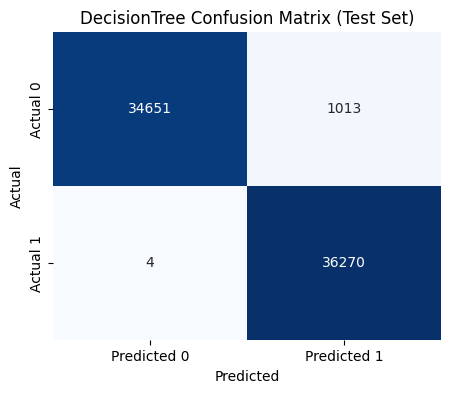


Model: RandomForest
Train Accuracy: 0.9859
Test Accuracy : 0.9859

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    142656
           1       0.97      1.00      0.99    145092

    accuracy                           0.99    287748
   macro avg       0.99      0.99      0.99    287748
weighted avg       0.99      0.99      0.99    287748

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938



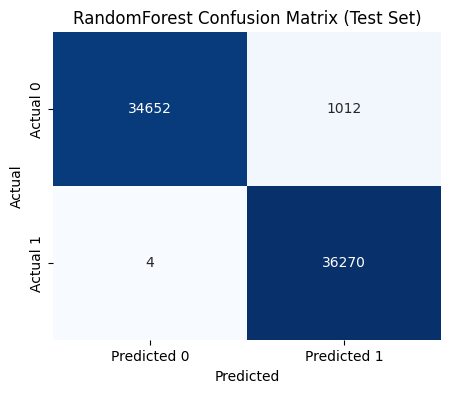


Model: GradientBoosting
Train Accuracy: 0.9858
Test Accuracy : 0.9859

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    142656
           1       0.97      1.00      0.99    145092

    accuracy                           0.99    287748
   macro avg       0.99      0.99      0.99    287748
weighted avg       0.99      0.99      0.99    287748

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938



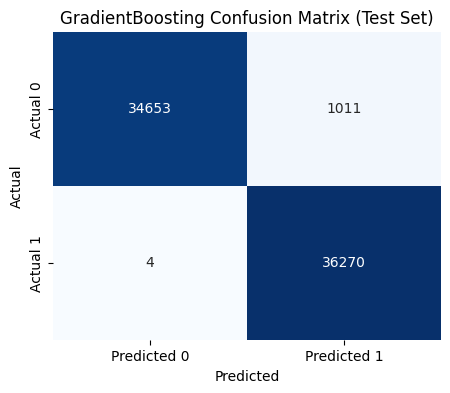


Model: LinearSVM
Train Accuracy: 0.5792
Test Accuracy : 0.5805

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.58      0.56      0.57    142656
           1       0.58      0.60      0.59    145092

    accuracy                           0.58    287748
   macro avg       0.58      0.58      0.58    287748
weighted avg       0.58      0.58      0.58    287748

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.58      0.56      0.57     35664
           1       0.58      0.60      0.59     36274

    accuracy                           0.58     71938
   macro avg       0.58      0.58      0.58     71938
weighted avg       0.58      0.58      0.58     71938



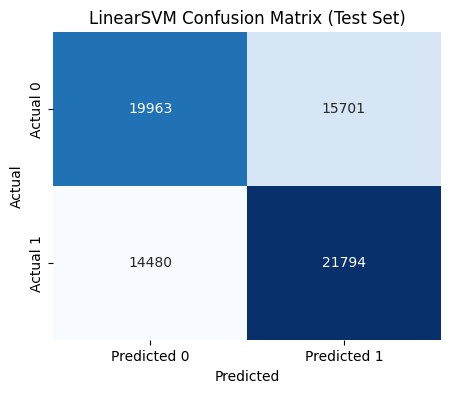

In [ ]:
# 3. Train and Evaluate Multiple Models

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LinearSVM': LinearSVC(max_iter=5000, random_state=42)
}

# Iterate over models
for name, model in models.items():
    # Pipeline: preprocessing + model
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train on training data
    pipe.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"Model: {name}")
    print("="*60)
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy : {test_acc:.4f}\n")
    
    # Classification Reports
    print("Classification Report (Training Set):")
    print(classification_report(y_train, y_train_pred))
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0','Predicted 1'],
                yticklabels=['Actual 0','Actual 1'])
    plt.title(f"{name} Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("="*60, "\n")

**Why Gradient Boosting:**

- Sequentially corrects errors from previous trees → higher accuracy.  
- Generalizes well on unseen data compared to a single Decision Tree.  
- More control via hyperparameters (`learning_rate`, `max_depth`, `subsample`) to reduce overfitting.  
- Focuses on hard-to-predict samples → fewer misclassifications than Random Forest.


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Model</th>
      <th>Test Accuracy</th>
      <th>F1 Macro</th>
      <th>F1 Weighted</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>GradientBoosting</td>
      <td>0.985891</td>
      <td>0.985883</td>
      <td>0.985886</td>
    </tr>
    <tr>
      <th>1</th>
      <td>RandomForest</td>
      <td>0.985877</td>
      <td>0.985870</td>
      <td>0.985872</td>
    </tr>
    <tr>
      <th>2</th>
      <td>DecisionTree</td>
      <td>0.985863</td>
      <td>0.985856</td>
      <td>0.985858</td>
    </tr>
    <tr>
      <th>3</th>
      <td>LogisticRegression</td>
      <td>0.581681</td>
      <td>0.581436</td>
      <td>0.581522</td>
    </tr>
    <tr>
      <th>4</th>
      <td>LinearSVM</td>
      <td>0.580458</td>
      <td>0.580186</td>
      <td>0.580277</td>
    </tr>
  </tbody>
</table>
</div>

### Hyperparameter Tuning for Best Model

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Smaller hyperparameter grid for faster tuning
param_dist = {
    'n_estimators': [50, 100, 150],        # reduced number of trees
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on scaled training data
random_search.fit(X_train_scaled, y_train)

# Best parameters and CV score
print("Best Hyperparameters:")
print(random_search.best_params_)
print("\nBest CV F1 score:")
print(random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters:
{'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}

Best CV F1 score:
0.986137610597536


 Train the Model with Best Hyperparameters

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train final model using best hyperparameters
best_gb = GradientBoostingClassifier(
    **random_search.best_params_,
    random_state=42
)
best_gb.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = best_gb.predict(X_train_scaled)
y_test_pred = best_gb.predict(X_test_scaled)

# --- Training set performance ---
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nTraining Set Report:")
print(classification_report(y_train, y_train_pred))

# --- Test set performance ---
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("\nTest Set Report:")
print(classification_report(y_test, y_test_pred))

# --- Confusion Matrix (Test Set) ---
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))


Train Accuracy: 0.9858348276964566

Training Set Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    142656
           1       0.97      1.00      0.99    145092

    accuracy                           0.99    287748
   macro avg       0.99      0.99      0.99    287748
weighted avg       0.99      0.99      0.99    287748

Test Accuracy : 0.985890628040813

Test Set Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938


Confusion Matrix (Test Set):
[[34653  1011]
 [    4 36270]]


Evaluate the Model on Test Set

Train Accuracy: 0.9858348276964566
Test Accuracy : 0.985890628040813

Training Set Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    142656
           1       0.97      1.00      0.99    145092

    accuracy                           0.99    287748
   macro avg       0.99      0.99      0.99    287748
weighted avg       0.99      0.99      0.99    287748


Test Set Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938



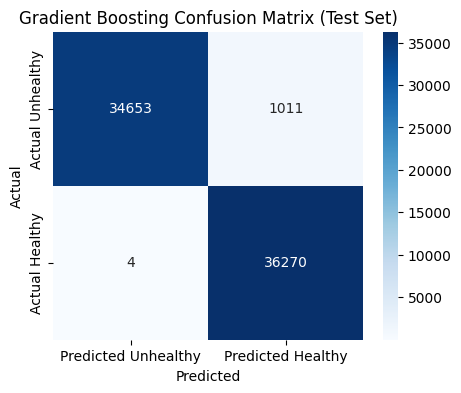

In [36]:
# Accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))

# Classification reports
print("\nTraining Set Report:\n", classification_report(y_train, y_train_pred))
print("\nTest Set Report:\n", classification_report(y_test, y_test_pred))

# Confusion Matrix (Test Set)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Unhealthy", "Predicted Healthy"],
            yticklabels=["Actual Unhealthy", "Actual Healthy"])
plt.title("Gradient Boosting Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Identify Misclassified Rows

In [37]:
# Combine original test features with true & predicted labels
test_results = X_test.copy()
test_results['Actual'] = y_test
test_results['Predicted'] = y_test_pred

# Misclassified rows
misclassified = test_results[test_results['Actual'] != test_results['Predicted']]
print("Number of misclassified rows:", misclassified.shape[0])

# Show a few misclassified rows
misclassified.head(10)


Number of misclassified rows: 1015


,humidity,temperature,hour,location_7,location_18,location_27,location_28,location_29,location_30,location_31,...,location_59,location_60,location_61,location_63,location_67,location_68,location_69,location_70,Actual,Predicted
42149,65.9,21.7,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
101481,65.9,21.7,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
13635,65.9,21.7,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
279684,65.9,21.7,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
95037,65.9,21.7,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
85037,65.9,21.7,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
17536,65.9,21.7,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
200053,65.9,21.7,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1
124163,65.9,21.7,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
267285,65.9,21.7,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1


The few misclassifications primarily occur in regions where humidity and temperature ranges for "Healthy" and "Unhealthy" air quality overlap.

Potential causes include:

Inherent sensor noise or measurement errors.
Imperfect outlier removal during preprocessing.
Natural, unavoidable overlap in environmental conditions.

### LEARNING CURVE

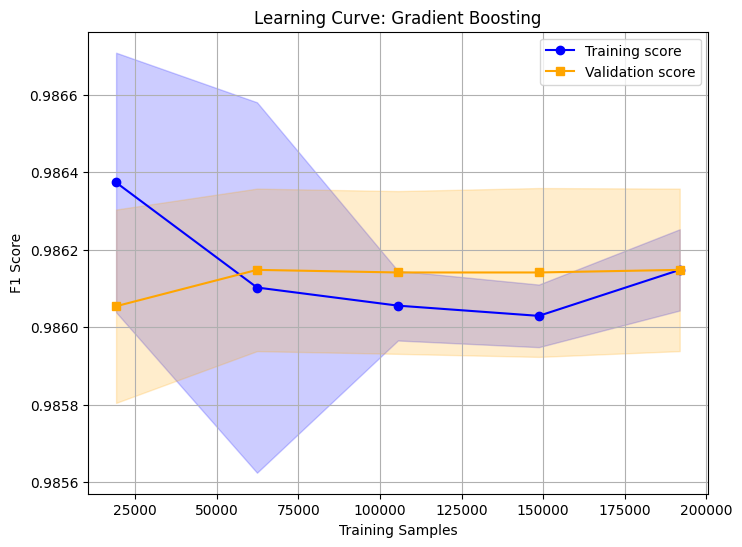

In [45]:
from sklearn.model_selection import learning_curve

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    GradientBoostingClassifier(**best_gb.get_params()),
    X_train_scaled,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=3,
    scoring="f1",
    n_jobs=-1
)

# Mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, color="blue", marker="o", label="Training score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, val_mean, color="orange", marker="s", label="Validation score")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, color="orange", alpha=0.2)
plt.title("Learning Curve: Gradient Boosting")
plt.xlabel("Training Samples")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend(loc="best")
plt.show()




 model is learning well as you add more data.

It’s not underfitting (since scores are high).

It’s not overfitting (since training and validation scores are close).

The training size of 150,000–200,000 seems to be enough — adding more data beyond that may not improve performance much.

### CONFUSION MATRIX

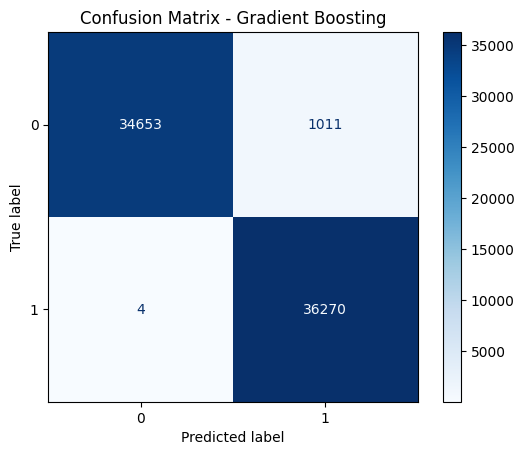

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_gb.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


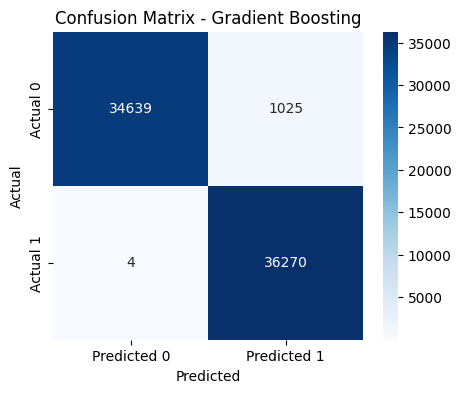

In [348]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted 0", "Predicted 1"], 
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### ROCK CURVE

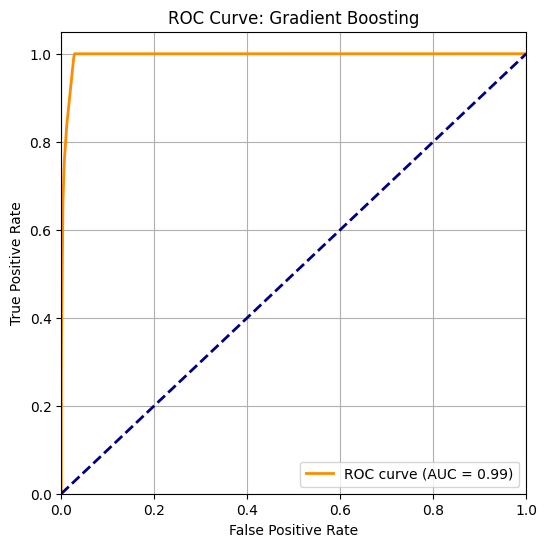

In [46]:
from sklearn.metrics import roc_curve, auc

# Probabilities
y_prob = best_gb.predict_proba(X_test_scaled)[:,1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Gradient Boosting")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Excellent classifier.

AUC = 0.99 means very high accuracy in distinguishing classes.

### PRECISION-RECALL CURVE

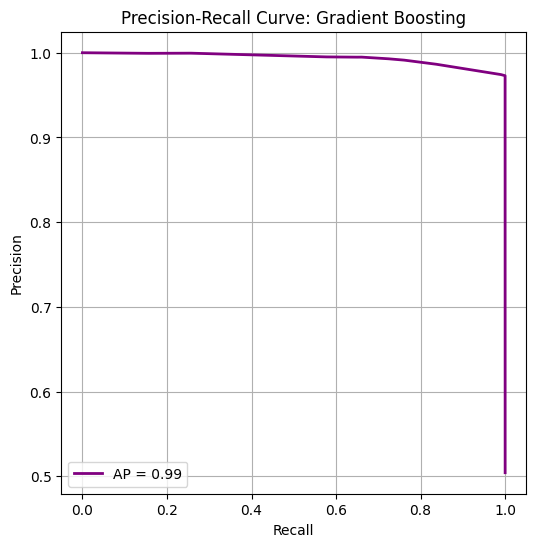

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Probabilities
y_prob = best_gb.predict_proba(X_test_scaled)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color="purple", lw=2, label=f"AP = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: Gradient Boosting")
plt.legend(loc="best")
plt.grid(True)
plt.show()


High precision: Very few false positives.

High recall: Almost all actual positives are correctly detected.

Average Precision = 0.99, which is excellent.

 Conclusion:

 Gradient Boosting model performs extremely well.

It correctly identifies positive cases while keeping false positives very low.

In [139]:
import joblib

# Save the Gradient Boosting model
joblib.dump(best_gb, "gb_model.pkl")

# Save the preprocessor (your ColumnTransformer)
joblib.dump(preprocessor, "preprocessor.pkl")


['preprocessor.pkl']

In [351]:
import joblib
joblib.dump(best_gb, "gradient_boosting_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")


['preprocessor.pkl']

In [352]:
import joblib
joblib.dump(best_gb, "gradient_boosting_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(X_train_res_scaled, "X_train.pkl")
joblib.dump(y_train_res, "y_train.pkl")


['y_train.pkl']